In [7]:
!uv add tensorflow scikit-learn pillow numpy pandas matplotlib seaborn tqdm h5py

Resolved 78 packages in 1.17s
Audited 77 packages in 36ms


In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configure TensorFlow for CPU optimization
import tensorflow as tf
tf.config.threading.set_intra_op_parallelism_threads(4)
tf.config.threading.set_inter_op_parallelism_threads(4)

print("✓ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")

✓ All libraries imported successfully!
TensorFlow version: 2.20.0
NumPy version: 2.3.4


In [11]:
# Configuration - Train on BOTH datasets
DATASET1_TRAIN_DIR = "dogs-vs-cats1/train"
DATASET2_TRAIN_DIR = "dogs-vs-cats2"
TEST_DIR_1 = "dogs-vs-cats1/test1"  # For testing
TEST_DIR_2 = "test"  # For testing

# Model parameters - Optimized for CPU
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
N_SAMPLES_PER_DATASET = 5000  # Samples from each dataset
PCA_COMPONENTS = 256
RANDOM_STATE = 42

print("=" * 70)
print("CONFIGURATION - TRAINING ON BOTH DATASETS")
print("=" * 70)
print(f"Dataset 1: {DATASET1_TRAIN_DIR}")
print(f"Dataset 2: {DATASET2_TRAIN_DIR}")
print(f"Test directories: {TEST_DIR_1}, {TEST_DIR_2}")
print(f"Image size: {IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Samples per dataset: {N_SAMPLES_PER_DATASET}")
print(f"Total training samples: ~{N_SAMPLES_PER_DATASET * 2}")
print(f"PCA components: {PCA_COMPONENTS}")
print("=" * 70)

CONFIGURATION - TRAINING ON BOTH DATASETS
Dataset 1: dogs-vs-cats1/train
Dataset 2: dogs-vs-cats2
Test directories: dogs-vs-cats1/test1, test
Image size: (224, 224)
Batch size: 16
Samples per dataset: 5000
Total training samples: ~10000
PCA components: 256


📦 Loading data from Dataset 1 (dogs-vs-cats1/train)...
✓ Dataset 1: 5000 images (Cats: 2500, Dogs: 2500)

📦 Loading data from Dataset 2 (dogs-vs-cats2)...
✓ Dataset 2: 5000 images (Cats: 2500, Dogs: 2500)

✅ TOTAL COMBINED: 10000 images
   Cats: 5000
   Dogs: 5000
✓ Dataset 1: 5000 images (Cats: 2500, Dogs: 2500)

📦 Loading data from Dataset 2 (dogs-vs-cats2)...
✓ Dataset 2: 5000 images (Cats: 2500, Dogs: 2500)

✅ TOTAL COMBINED: 10000 images
   Cats: 5000
   Dogs: 5000


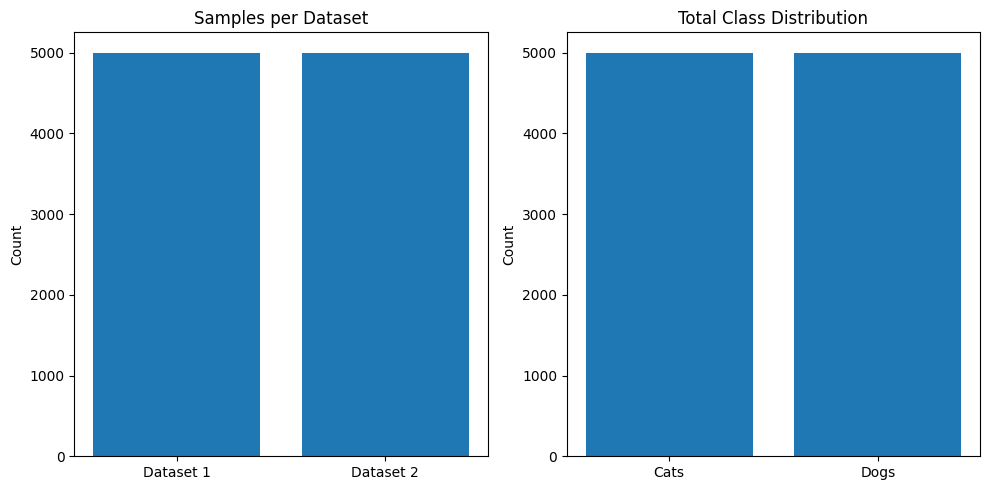

In [ ]:
def get_image_paths_and_labels(data_dir, max_samples=None, subdirs=False):
    """
    Get image paths and labels from directory
    Args:
        data_dir: Directory containing images
        max_samples: Maximum samples to load
        subdirs: If True, expects Cat/ and Dog/ subdirectories. Otherwise expects cat.*.jpg format
    """
    image_paths = []
    labels = []
    
    if not os.path.exists(data_dir):
        print(f"❌ Directory not found: {data_dir}")
        return [], []
    
    if subdirs:
        # Load from Cat/ and Dog/ subdirectories
        cat_dir = os.path.join(data_dir, "Cat")
        dog_dir = os.path.join(data_dir, "Dog")
        
        cat_files = []
        dog_files = []
        
        if os.path.exists(cat_dir):
            cat_files = [os.path.join(cat_dir, f) for f in os.listdir(cat_dir) 
                        if f.endswith(('.jpg', '.jpeg', '.png'))]
        
        if os.path.exists(dog_dir):
            dog_files = [os.path.join(dog_dir, f) for f in os.listdir(dog_dir) 
                        if f.endswith(('.jpg', '.jpeg', '.png'))]
        
        if max_samples:
            cat_files = cat_files[:max_samples//2]
            dog_files = dog_files[:max_samples//2]
        
        # Add cat images
        for path in cat_files:
            image_paths.append(path)
            labels.append(0)  # 0 for cat
        
        # Add dog images
        for path in dog_files:
            image_paths.append(path)
            labels.append(1)  # 1 for dog
    else:
        # Load from flat directory with cat.*.jpg, dog.*.jpg format
        files = os.listdir(data_dir)
        
        if max_samples:
            # Balance the dataset - equal cats and dogs
            cat_files = [f for f in files if 'cat' in f.lower()][:max_samples//2]
            dog_files = [f for f in files if 'dog' in f.lower()][:max_samples//2]
            files = cat_files + dog_files
        else:
            files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png'))]
        
        for filename in files:
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(data_dir, filename))
                # Label: 0 for cat, 1 for dog
                labels.append(0 if 'cat' in filename.lower() else 1)
    
    return image_paths, labels

print("Loading data from Dataset 1 (dogs-vs-cats1/train)...")
dataset1_paths, dataset1_labels = get_image_paths_and_labels(DATASET1_TRAIN_DIR, max_samples=N_SAMPLES_PER_DATASET, subdirs=False)
print(f"✓ Dataset 1: {len(dataset1_paths)} images (Cats: {sum(1 for l in dataset1_labels if l == 0)}, Dogs: {sum(1 for l in dataset1_labels if l == 1)})")

print("\nLoading data from Dataset 2 (dogs-vs-cats2)...")
dataset2_paths, dataset2_labels = get_image_paths_and_labels(DATASET2_TRAIN_DIR, max_samples=N_SAMPLES_PER_DATASET, subdirs=True)
print(f"✓ Dataset 2: {len(dataset2_paths)} images (Cats: {sum(1 for l in dataset2_labels if l == 0)}, Dogs: {sum(1 for l in dataset2_labels if l == 1)})")

# Combine both datasets
train_paths = dataset1_paths + dataset2_paths
train_labels = dataset1_labels + dataset2_labels

print(f"\n✅ TOTAL COMBINED: {len(train_paths)} images")
print(f"   Cats: {sum(1 for l in train_labels if l == 0)}")
print(f"   Dogs: {sum(1 for l in train_labels if l == 1)}")

# Visualize distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(['Dataset 1', 'Dataset 2'], [len(dataset1_paths), len(dataset2_paths)])
plt.title('Samples per Dataset')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.bar(['Cats', 'Dogs'], [sum(1 for l in train_labels if l == 0), 
                           sum(1 for l in train_labels if l == 1)])
plt.title('Total Class Distribution')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [ ]:
# Create VGG16 feature extractor with Global Average Pooling
print("Creating VGG16 feature extractor...")

# Load VGG16 without top layers
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Add Global Average Pooling to reduce to 512 features
x = GlobalAveragePooling2D()(base_model.output)
feature_extractor = Model(inputs=base_model.input, outputs=x)

# Freeze all layers
for layer in feature_extractor.layers:
    layer.trainable = False

print("✓ Feature extractor created!")
print(f"   Input shape: {feature_extractor.input_shape}")
print(f"   Output shape: {feature_extractor.output_shape}")

# Test with dummy input
dummy_input = np.random.rand(1, 224, 224, 3)
dummy_output = feature_extractor.predict(dummy_input, verbose=0)
print(f"   Output features: {dummy_output.shape[1]} dimensions")

🔧 Creating VGG16 feature extractor...
✓ Feature extractor created!
   Input shape: (None, 224, 224, 3)
   Output shape: (None, 512)
✓ Feature extractor created!
   Input shape: (None, 224, 224, 3)
   Output shape: (None, 512)
   Output features: 512 dimensions
   Output features: 512 dimensions


In [ ]:
def load_and_extract_features(image_paths, labels, feature_extractor, batch_size=16):
    """
    Load images in batches and extract features
    Optimized for CPU with smaller batches
    """
    all_features = []
    valid_labels = []
    
    print(f"Processing {len(image_paths)} images in batches of {batch_size}...")
    
    for i in tqdm(range(0, len(image_paths), batch_size)):
        batch_paths = image_paths[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]
        batch_images = []
        batch_valid_labels = []
        
        # Load batch images
        for img_path, label in zip(batch_paths, batch_labels):
            try:
                img = load_img(img_path, target_size=IMG_SIZE)
                img_array = img_to_array(img)
                img_array = preprocess_input(img_array)
                batch_images.append(img_array)
                batch_valid_labels.append(label)
            except Exception as e:
                print(f"⚠ Error loading {img_path}: {e}")
                continue
        
        if len(batch_images) > 0:
            # Extract features for this batch
            batch_images = np.array(batch_images)
            batch_features = feature_extractor.predict(batch_images, verbose=0)
            all_features.append(batch_features)
            valid_labels.extend(batch_valid_labels)
    
    # Concatenate all features
    all_features = np.vstack(all_features)
    valid_labels = np.array(valid_labels)
    
    return all_features, valid_labels

# Extract features from training data
print("\nExtracting features from training images...")
train_features, train_labels_valid = load_and_extract_features(
    train_paths, 
    train_labels, 
    feature_extractor, 
    batch_size=BATCH_SIZE
)

print("\n✓ Features extracted!")
print(f"   Feature shape: {train_features.shape}")
print(f"   Labels shape: {train_labels_valid.shape}")
print(f"   Feature dimension: {train_features.shape[1]}")


🔍 Extracting features from training images...
Processing 10000 images in batches of 16...


 12%|█▏        | 74/625 [05:03<38:58,  4.24s/it]

In [ ]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(
    train_features, 
    train_labels_valid, 
    test_size=0.2, 
    random_state=RANDOM_STATE,
    stratify=train_labels_valid
)

print("Data split:")
print(f"   Training samples: {X_train.shape[0]}")
print(f"   Validation samples: {X_val.shape[0]}")
print(f"\n   Training - Cats: {sum(y_train == 0)}, Dogs: {sum(y_train == 1)}")
print(f"   Validation - Cats: {sum(y_val == 0)}, Dogs: {sum(y_val == 1)}")

In [ ]:
# Apply PCA
print(f"\nApplying PCA ({PCA_COMPONENTS} components)...")
pca = PCA(n_components=PCA_COMPONENTS, random_state=RANDOM_STATE)

# Fit on training data and transform both train and validation
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

# Calculate explained variance
explained_variance = pca.explained_variance_ratio_.sum()

print("✓ PCA complete!")
print(f"   Original dimensions: {X_train.shape[1]}")
print(f"   Reduced dimensions: {X_train_pca.shape[1]}")
print(f"   Explained variance: {explained_variance:.2%}")

# Visualize explained variance
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title(f'PCA Explained Variance (Total: {explained_variance:.2%})')
plt.grid(True)
plt.axhline(y=explained_variance, color='r', linestyle='--', 
            label=f'{PCA_COMPONENTS} components: {explained_variance:.2%}')
plt.legend()
plt.show()

In [ ]:
# Apply StandardScaler
print("\nApplying Standard Scaling...")
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_pca)
X_val_scaled = scaler.transform(X_val_pca)

print("✓ Scaling complete!")
print(f"   Training mean: {X_train_scaled.mean():.6f}")
print(f"   Training std: {X_train_scaled.std():.6f}")

In [ ]:
# Define SVM with probability estimates
print("\nTraining SVM classifier...")
print("   Using GridSearchCV for hyperparameter optimization")

# Reduced parameter grid for faster training
param_grid = {
    'C': [1, 10, 100],
    'gamma': ['scale', 0.001, 0.01],
    'kernel': ['rbf']
}

# Create SVM
svm_model = svm.SVC(random_state=RANDOM_STATE, probability=True, cache_size=1000)

# Grid search with 3-fold CV (faster than 5-fold)
grid_search = GridSearchCV(
    svm_model,
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,  # Use all CPU cores
    verbose=2
)

# Fit the model
print("\nTraining started...")
grid_search.fit(X_train_scaled, y_train)

# Get best model
best_svm = grid_search.best_estimator_

print("\n✓ Training complete!")
print(f"   Best parameters: {grid_search.best_params_}")
print(f"   Best CV score: {grid_search.best_score_:.4f}")

In [ ]:
# Make predictions on validation set
print("\nEvaluating model on validation set...")
val_predictions = best_svm.predict(X_val_scaled)
val_probabilities = best_svm.predict_proba(X_val_scaled)

# Calculate metrics
val_accuracy = accuracy_score(y_val, val_predictions)

print(f"\n✓ Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_val, val_predictions, 
                          target_names=['Cat', 'Dog']))

# Confusion Matrix
cm = confusion_matrix(y_val, val_predictions)
print("\nConfusion Matrix:")
print(cm)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Cat', 'Dog'], 
            yticklabels=['Cat', 'Dog'])
plt.title(f'Confusion Matrix - Validation Accuracy: {val_accuracy:.2%}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
def predict_single_image(img_path, feature_extractor, pca, scaler, svm_model):
    """
    Predict single image with confidence
    """
    try:
        # Load and preprocess
        img = load_img(img_path, target_size=IMG_SIZE)
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        img_array = np.expand_dims(img_array, axis=0)
        
        # Extract features
        features = feature_extractor.predict(img_array, verbose=0)
        
        # Apply PCA
        features_pca = pca.transform(features)
        
        # Apply scaling
        features_scaled = scaler.transform(features_pca)
        
        # Predict
        prediction = svm_model.predict(features_scaled)[0]
        probability = svm_model.predict_proba(features_scaled)[0]
        confidence = probability[prediction]
        
        return prediction, confidence, probability
    except Exception as e:
        print(f"Error predicting {img_path}: {e}")
        return None, None, None

# Test on images from both test directories
test_dirs = [TEST_DIR_1, TEST_DIR_2]

for test_dir in test_dirs:
    if os.path.exists(test_dir):
        print(f"\n{'='*70}")
        print(f"Testing on images from {test_dir}/")
        print('='*70)
        test_images = [f for f in os.listdir(test_dir) 
                       if f.endswith(('.jpg', '.jpeg', '.png'))]
        
        results = []
        for img_name in sorted(test_images)[:10]:  # Test first 10 images
            img_path = os.path.join(test_dir, img_name)
            pred, conf, prob = predict_single_image(
                img_path, feature_extractor, pca, scaler, best_svm
            )
            
            if pred is not None:
                label = "Cat" if pred == 0 else "Dog"
                # Try to determine expected label from filename
                if 'cat' in img_name.lower():
                    expected = "Cat"
                elif 'dog' in img_name.lower():
                    expected = "Dog"
                else:
                    expected = "Unknown"
                
                correct = "✓" if (expected == "Unknown" or label == expected) else "✗"
                
                results.append({
                    'Image': img_name,
                    'Expected': expected,
                    'Predicted': label,
                    'Confidence': f'{conf:.2%}',
                    'Correct': correct
                })
                
                print(f"{correct} {img_name:20s} | Expected: {expected:7s} | "
                      f"Predicted: {label:3s} | Confidence: {conf:.2%}")
        
        # Summary
        if results:
            df_results = pd.DataFrame(results)
            known_results = df_results[df_results['Expected'] != 'Unknown']
            if len(known_results) > 0:
                accuracy = sum(known_results['Correct'] == '✓') / len(known_results)
                print(f"\nTest Set Accuracy: {accuracy:.2%} ({sum(known_results['Correct'] == '✓')}/{len(known_results)})")
            else:
                print(f"\nTested {len(df_results)} images (labels unknown)")
    else:
        print(f"\n⚠️  Test directory not found: {test_dir}")

In [ ]:
import h5py

# Save complete model as .keras file
print("\nSaving complete model...")

# Create a custom model that includes everything
model_path = 'cats-vs-dogs.keras'

# Save feature extractor
feature_extractor.save(model_path)
print(f"✓ Feature extractor saved: {model_path}")

# Save PCA, Scaler, and SVM as separate .keras file using h5py
components_path = 'cats-vs-dogs.keras'
with h5py.File(components_path, 'w') as f:
    # Save config
    config_grp = f.create_group('config')
    config_grp.attrs['img_size_0'] = IMG_SIZE[0]
    config_grp.attrs['img_size_1'] = IMG_SIZE[1]
    config_grp.attrs['pca_components'] = PCA_COMPONENTS
    config_grp.attrs['val_accuracy'] = val_accuracy
    config_grp.attrs['best_C'] = grid_search.best_params_['C']
    config_grp.attrs['best_gamma'] = str(grid_search.best_params_['gamma'])
    config_grp.attrs['best_kernel'] = grid_search.best_params_['kernel']
    
    # Save PCA components and parameters
    pca_grp = f.create_group('pca')
    pca_grp.create_dataset('components', data=pca.components_)
    pca_grp.create_dataset('mean', data=pca.mean_)
    pca_grp.create_dataset('explained_variance', data=pca.explained_variance_)
    pca_grp.attrs['n_components'] = pca.n_components_
    
    # Save Scaler parameters
    scaler_grp = f.create_group('scaler')
    scaler_grp.create_dataset('mean', data=scaler.mean_)
    scaler_grp.create_dataset('scale', data=scaler.scale_)
    
    # Save SVM parameters
    svm_grp = f.create_group('svm')
    svm_grp.create_dataset('support_vectors', data=best_svm.support_vectors_)
    svm_grp.create_dataset('dual_coef', data=best_svm.dual_coef_)
    svm_grp.create_dataset('intercept', data=best_svm.intercept_)
    svm_grp.create_dataset('support', data=best_svm.support_)
    svm_grp.attrs['gamma'] = best_svm.gamma if isinstance(best_svm.gamma, (int, float)) else str(best_svm.gamma)
    svm_grp.attrs['C'] = best_svm.C
    svm_grp.attrs['kernel'] = best_svm.kernel
    svm_grp.attrs['n_support_0'] = best_svm.n_support_[0]
    svm_grp.attrs['n_support_1'] = best_svm.n_support_[1]

print(f"✓ Model components saved: {components_path}")

print("\nModel files:")
print(f"   {model_path} - {os.path.getsize(model_path) / (1024*1024):.1f} MB")
print(f"   {components_path} - {os.path.getsize(components_path) / (1024*1024):.1f} MB")
print("\n✅ Training complete! All models saved in .keras format!")

In [ ]:
print("=" * 70)
print("MODEL TRAINING SUMMARY")
print("=" * 70)
print("\nDataset:")
print(f"   Dataset 1 samples: {len(dataset1_paths)}")
print(f"   Dataset 2 samples: {len(dataset2_paths)}")
print(f"   Total training: {len(y_train)}")
print(f"   Validation: {len(y_val)}")

print("\nArchitecture:")
print("   Feature Extractor: VGG16 + Global Average Pooling")
print(f"   Feature Dimension: 512 → {PCA_COMPONENTS} (PCA)")
print(f"   Classifier: SVM with {grid_search.best_params_['kernel']} kernel")

print("\nBest Hyperparameters:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")

print("\nPerformance:")
print(f"   Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"   Explained Variance (PCA): {explained_variance:.2%}")

print("\nModel Files (Keras Format):")
print(f"   {model_path} ({os.path.getsize(model_path) / (1024*1024):.1f} MB)")
print(f"   {components_path} ({os.path.getsize(components_path) / (1024*1024):.1f} MB)")

print("\n" + "=" * 70)
print("✅ Ready for inference! Use inference.py to test on new images.")
print("=" * 70)